## **Product similarity**

This notebook demonstrates the processes of building, traing/finetuning and benchmarking of Siamese-based models in product matching application.  
  
This is a binary text classification task where pairs of products are fed into a Siamese network to produce a final prediction (1 means the products are similar, 0 means they are different).  
  
For example:
* iphone 14 pro max, iphone 14 pro max version 2022 : label 1
* iphone 14 pro, samsung galaxy s21: label 0

<br>

### **Siamese networks**

<img alt="Siamese Networks" width="500" caption="Siamese network in computer vision" src="https://b2633864.smushcdn.com/2633864/wp-content/uploads/2020/11/keras_siamese_networks_header.png?lossy=1&strip=1&webp=1" id="siamese-network"/>

*Siamese network in computer vision*   
*Source: https://pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/*

A Siamese network is a neural network comprises of 2 sister base models sharing the same weight. The outputs of the base models are joined by a matching layer and the architecture proceeds with one or more layers to produce the desired output.

<br>


### **Base models**
In this work, the base models used for the Siamese network were __*pretrained Distilbert Transformer*__ and __*GRU*__.

<br>

### **Join mechanisms**
To join the outputs of the sister models, two different operations were employed:  
  
1. **absolute difference**: 
* |base output 1 - base output 2|
* when time dimension was absent
* i.e., when using transformer *CLS tokens*, or GRU output with *return_sequences=False*

2. **dot products**
* matrix multiplication of two outputs, dot(base output 1, base output 2)
* when time dimension was present
* i.e., using *last_hidden_state* of *transformers*, or GRU output with *return_sequences=True*  
* follwing this operation was a **global max pooling layer**

The two operations, to a certain extent, respectively resemble the *representation model architecture* and *interactive model architecture* discussed in this paper: https://iopscience.iop.org/article/10.1088/1742-6596/1684/1/012074. The original idea in this paper is also the motivation and reference of this work.

<br>

### **Benchmarking**
The benchmarking was based on the validation accuracy during training and the test accuracy evaluated on the test set.  
  
Result discussion is at the end of the notebook.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report

!pip install transformers
from transformers import AutoTokenizer, TFAutoModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.6 MB/s eta 0:00:00


## Dataset

In [2]:
# Download dataset

!gdown https://drive.google.com/uc?id=1Fw-pRLeOFSv_To6ZX4kqXiizIVpxTYdJ&export=download

Downloading...
From: https://drive.google.com/uc?id=1Fw-pRLeOFSv_To6ZX4kqXiizIVpxTYdJ
To: /content/all_train.zip
100% 57.6M/57.6M [00:01<00:00, 34.5MB/s]


In [3]:
# Unzip dataset

!unzip 'all_train.zip'

Archive:  all_train.zip
  inflating: all_train_large.json.gz  
  inflating: all_train_medium.json.gz  
  inflating: all_train_small.json.gz  
  inflating: all_train_xlarge.json.gz  


In [4]:
# Use 'small' dataset

df = pd.read_json('all_train_small.json.gz', lines=True, compression='gzip')
df.head()

,id_left,title_left,description_left,brand_left,price_left,specTableContent_left,keyValuePairs_left,category_left,cluster_id_left,identifiers_left,...,description_right,brand_right,price_right,specTableContent_right,keyValuePairs_right,category_right,cluster_id_right,identifiers_right,label,pair_id
0,16876009,"495906 b21 hp x5560 2 80ghz ml350 g6 , null ne...",description intel xeon x5560 ml350 g6 2 80ghz ...,hp enterprise,None,specifications category proliant processor sub...,"{'category': 'proliant processor', 'sub catego...",Computers_and_Accessories,1679624,"[{'/sku': '[495906b21]'}, {'/mpn': '[495906b21...",...,description intel xeon x5560 ml350 g6 2 80ghz ...,hp enterprise,usd 213 85,specifications category proliant processor sub...,"{'category': 'proliant processor', 'sub catego...",Computers_and_Accessories,1679624,[{'/mpn': '[495906b21]'}],1,16876009#16248399
1,16543750,asus motherboard lga2066 ddr4 m 2 u atx 2xgbe ...,None,None,None,None,None,Computers_and_Accessories,109916,"[{'/sku': '[34181655]'}, {'/mpn': '[primex299d...",...,None,None,None,categorie moederborden merk asus product asus ...,"{'categorie': 'moederborden', 'merk': 'asus', ...",Computers_and_Accessories,109916,"[{'/mpn': '[primex299deluxe, 90mb0ty0m0eay0]'...",1,16543750#16721450
2,3702134,asrock h81m dgs r2 0 micro atx motherboard ln6...,asrock h81m dgs r2 0 intel h81 s 1150 ddr3 sat...,None,None,None,None,Computers_and_Accessories,189457,[{'/mpn': '[h81mdgsr20]'}],...,None,None,None,categorie moederborden merk asrock product asr...,"{'categorie': 'moederborden', 'merk': 'asrock'...",Computers_and_Accessories,189457,"[{'/mpn': '[h81mdgsr20, 90mxgsr0a0uayz]'}, {'...",1,3702134#8670870
3,17008923,"533995 b22 hp xeon x3220 2 4ghz dl120 g5 , null",description intel xeon processor x3220 dl120 g...,hp enterprise,2 984 74 cad cad,specifications category proliant processor sub...,"{'category': 'proliant processor', 'sub catego...",Computers_and_Accessories,4703255,[{'/mpn': '[533995b22]'}],...,description intel xeon processor x3220 dl120 g...,hp enterprise,None,specifications category proliant processor sub...,"{'category': 'proliant processor', 'sub catego...",Computers_and_Accessories,4703255,"[{'/sku': '[533995b22]'}, {'/mpn': '[533995b22...",1,17008923#15072768
4,17090954,"null , mba3147np fujitsu 146 gb u320 scsi nhp 15k",description fujitsu 146gb ultra320 3 5 inchscs...,fujitsu,389 94 cad cad,None,None,Computers_and_Accessories,4682367,[{'/mpn': '[mba3147np]'}],...,description fujitsu 146gb ultra320 3 5 inchscs...,fujitsu,None,None,None,Computers_and_Accessories,4682367,"[{'/sku': '[mba3147np]'}, {'/mpn': '[mba3147np...",1,17090954#17474367


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9038 entries, 0 to 9037
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id_left                 9038 non-null   int64 
 1   title_left              9038 non-null   object
 2   description_left        5947 non-null   object
 3   brand_left              3216 non-null   object
 4   price_left              861 non-null    object
 5   specTableContent_left   1777 non-null   object
 6   keyValuePairs_left      1400 non-null   object
 7   category_left           9038 non-null   object
 8   cluster_id_left         9038 non-null   int64 
 9   identifiers_left        9038 non-null   object
 10  id_right                9038 non-null   int64 
 11  title_right             9038 non-null   object
 12  description_right       5875 non-null   object
 13  brand_right             3099 non-null   object
 14  price_right             751 non-null    object
 15  spec

## Data Preprocessing

In [6]:
# Remove redundant columns

df = df.loc[:, ['title_left', 'title_right', 'label']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9038 entries, 0 to 9037
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title_left   9038 non-null   object
 1   title_right  9038 non-null   object
 2   label        9038 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 212.0+ KB


In [7]:
df.head()

,title_left,title_right,label
0,"495906 b21 hp x5560 2 80ghz ml350 g6 , null ne...","null , 495906 b21 hp x5560 2 80ghz ml350 g6",1
1,asus motherboard lga2066 ddr4 m 2 u atx 2xgbe ...,asus prime x299 deluxe prijzen tweakers,1
2,asrock h81m dgs r2 0 micro atx motherboard ln6...,asrock h81m dgs r2 0 prijzen tweakers,1
3,"533995 b22 hp xeon x3220 2 4ghz dl120 g5 , null","null , 533995 b22 hp xeon x3220 2 4ghz dl120 g...",1
4,"null , mba3147np fujitsu 146 gb u320 scsi nhp 15k","null , mba3147np fujitsu 146 gb u320 scsi nhp ...",1


In [8]:
def plot_label_distribution(data):

    print('Label Counts')
    print(data['label'].value_counts())
    fig, axes = plt.subplots(1, 2, figsize=(9, 3))
    fig.suptitle('Label Distribution')
    # Counts
    fig1 = sns.countplot(ax=axes[0], data=data, x='label', orient='v')
    # Normalize
    data_normalized = pd.DataFrame(data['label'].value_counts(1)).reset_index()
    data_normalized.columns = ['label', 'normalised_ratio']
    fig2 =sns.barplot(data=data_normalized, x='label', y='normalised_ratio')
    plt.show()

Label Counts
0    6720
1    2318
Name: label, dtype: int64


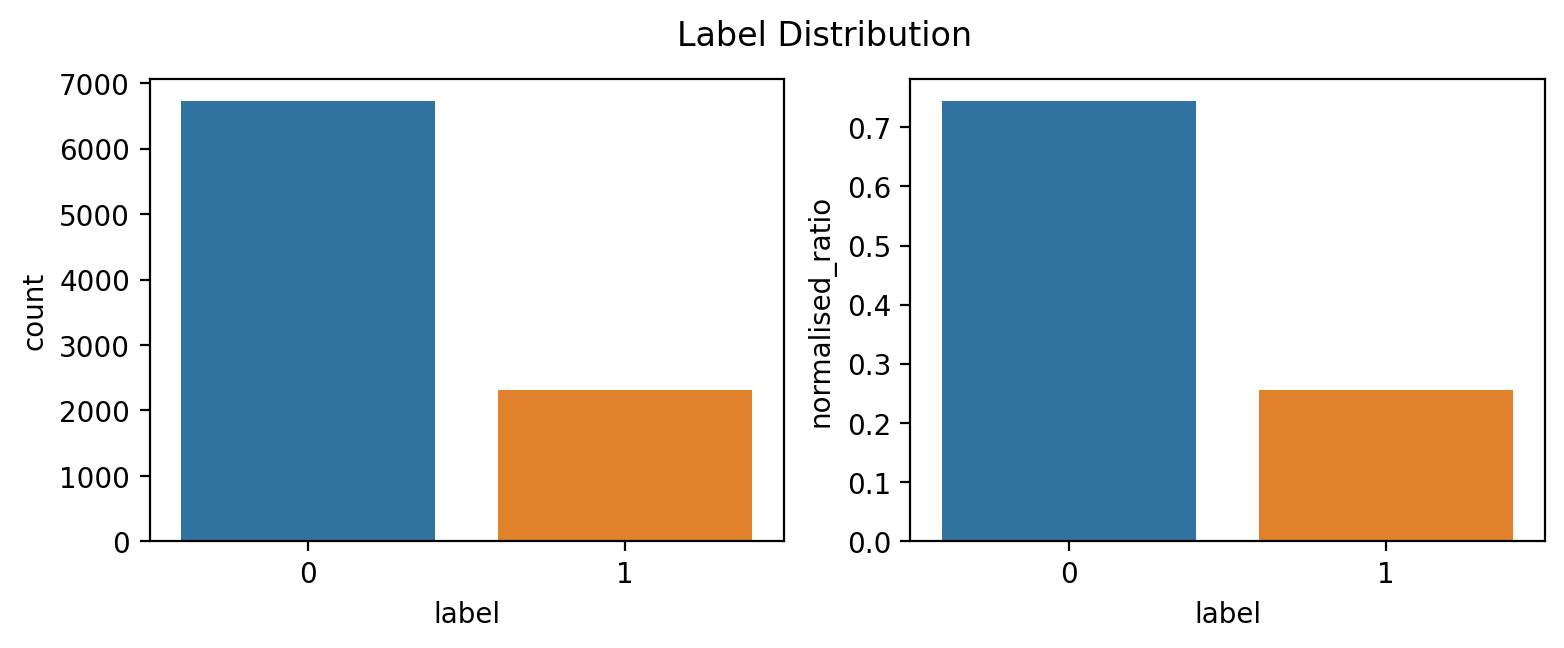

In [9]:
# Plot label distribution

plot_label_distribution(df)

Within the scope of this project, we'll work on balanced dataset to train and benchmark the models.

In [10]:
# Undersample to balance the dataset

np.random.seed = 42
set_count = 2 * len(df[df['label']==0]) - len(df)
pool = df[df['label']==0].index.values
removed_idx = np.random.choice(pool, size=set_count, replace=False)
df = df.drop(removed_idx, axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4636 entries, 0 to 9036
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title_left   4636 non-null   object
 1   title_right  4636 non-null   object
 2   label        4636 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 144.9+ KB


Label Counts
1    2318
0    2318
Name: label, dtype: int64


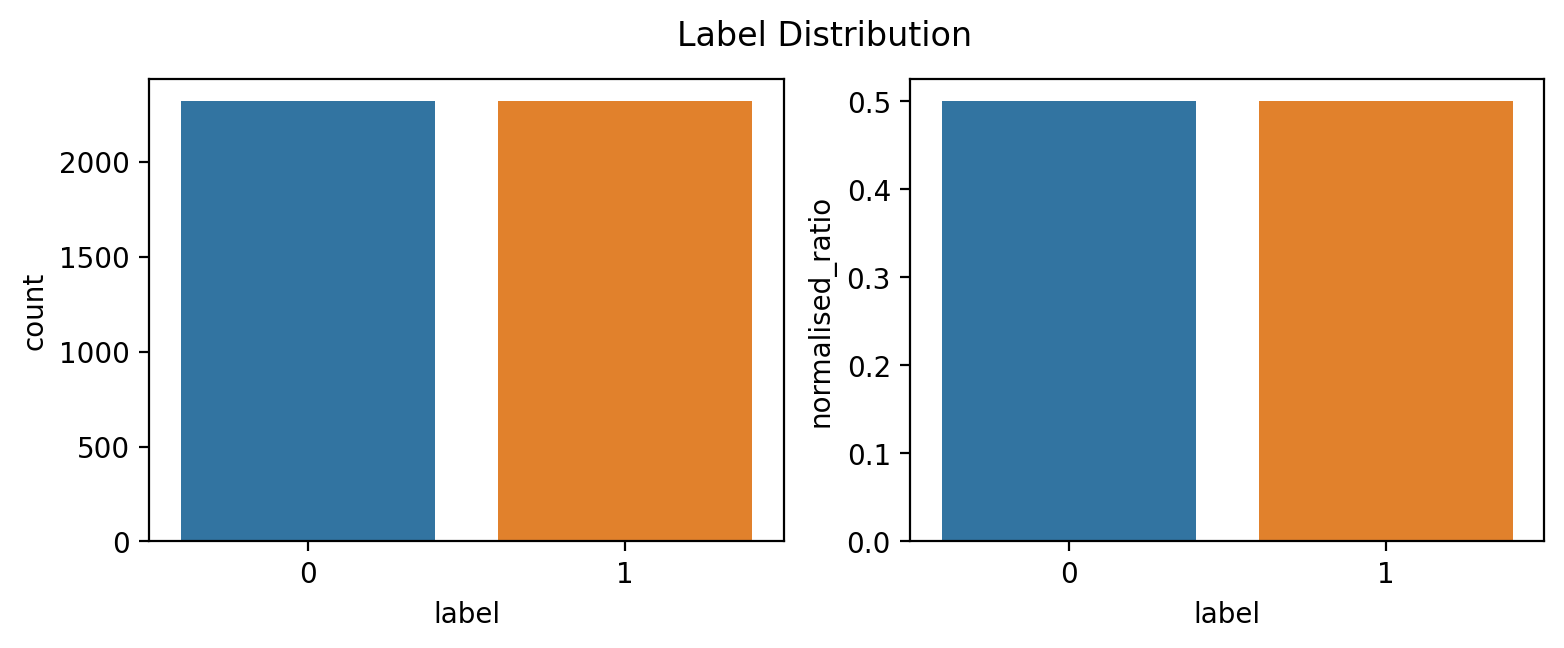

In [11]:
# Plot new label distribution

plot_label_distribution(df)

In [12]:
ds = df.values

## Siamese-Transformers

In [13]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Tokenize

In [14]:
from transformers import AutoTokenizer

# Model checkpoint
ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(ckpt)


# Tokenization function
max_length = 100

def encode(x):
    encoded = tokenizer(x, padding='max_length', 
                        truncation=True, 
                        max_length=max_length,
                        return_tensors='tf')
    return tf.squeeze(encoded['input_ids']), tf.squeeze(encoded['attention_mask'])
    

first_X_tokenized = [encode(x) for x in ds[:, 0]]
second_X_tokenized = [encode(x) for x in ds[:, 1]]

first_X_tokenized = np.array(first_X_tokenized)
second_X_tokenized = np.array(second_X_tokenized)
first_X_tokenized.shape, second_X_tokenized.shape

((4636, 2, 100), (4636, 2, 100))

In [15]:
# Split to train and test sets

X_tokenized = np.stack((first_X_tokenized, second_X_tokenized), axis=1)
y = ds[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_tokenized, y, 
                                                      test_size=0.2, 
                                                      random_state=42, 
                                                      shuffle=True)

X_train_ids_1, X_train_ids_2, X_train_mask_1, X_train_mask_2 = X_train[:, 0, 0, :], X_train[:, 1, 0, :], X_train[:, 0, 1, :], X_train[:, 1, 1, :]
X_test_ids_1, X_test_ids_2, X_test_mask_1, X_test_mask_2 = X_test[:, 0, 0, :], X_test[:, 1, 0, :], X_test[:, 0, 1, :], X_test[:, 1, 1, :]

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

### Preparation step for training

In [16]:
# Function to plot loss and accuracy

def plot_history(history):

    # Plot Accuracy
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy')
    plt.legend(['train', 'validation'])
    plt.show()

    # Plot Loss
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.legend(['train', 'validation'])
    plt.show()

In [17]:
# Dictionary to store training history and evaluation scores

results = {}

In [18]:
# Set these hyperparameters to be constant for benchmarking

BATCH_SIZE = 64
EPOCHS = 5
LR = 1e-4
loss_func='binary_crossentropy'
metric = ['accuracy']

### 1.1. Siamese-Transformer using CLS token (absolute difference)



In [19]:
# Build model

bert = TFAutoModel.from_pretrained(ckpt)
tf.random.set_seed(42)

# Inputs
a = keras.layers.Input(shape=(max_length, ), dtype=tf.int32)
a_mask = keras.layers.Input(shape=(max_length, ), dtype=tf.int32)
b = keras.layers.Input(shape=(max_length, ), dtype=tf.int32)
b_mask = keras.layers.Input(shape=(max_length, ), dtype=tf.int32)

a_dict = {'input_ids': a, 
          'attention_mask': a_mask}
b_dict = {'input_ids': b,
          'attention_mask': b_mask}

# CLS tokens
a_bert_cls = bert(a_dict).last_hidden_state[:, 0, :]
b_bert_cls = bert(b_dict).last_hidden_state[:, 0, :]

# Absolute difference
e = keras.layers.Subtract()([a_bert_cls, b_bert_cls])
e = keras.layers.Lambda(lambda x: abs(x))(e)

# Ouput
output = keras.layers.Dense(1, activation='sigmoid')(e)
siamese_bert_cls = keras.Model(inputs=[a, b, a_mask, b_mask], outputs=output)

siamese_bert_cls.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                              

Epoch 1/5
47/47 [==============================] - 85s 1s/step - loss: 0.6962 - accuracy: 0.5071 - val_loss: 0.6845 - val_accuracy: 0.5458
Epoch 2/5
47/47 [==============================] - 56s 1s/step - loss: 0.6594 - accuracy: 0.6170 - val_loss: 0.6285 - val_accuracy: 0.5620
Epoch 3/5
47/47 [==============================] - 59s 1s/step - loss: 0.5381 - accuracy: 0.7664 - val_loss: 0.6599 - val_accuracy: 0.5633
Epoch 4/5
47/47 [==============================] - 58s 1s/step - loss: 0.3991 - accuracy: 0.8486 - val_loss: 0.7158 - val_accuracy: 0.6199
Epoch 5/5
47/47 [==============================] - 58s 1s/step - loss: 0.2497 - accuracy: 0.9221 - val_loss: 0.7562 - val_accuracy: 0.6523


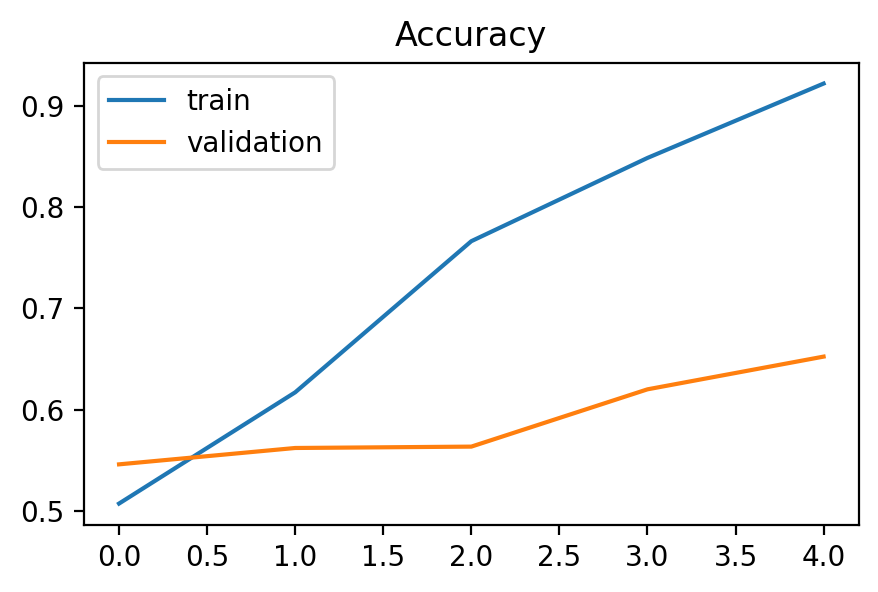

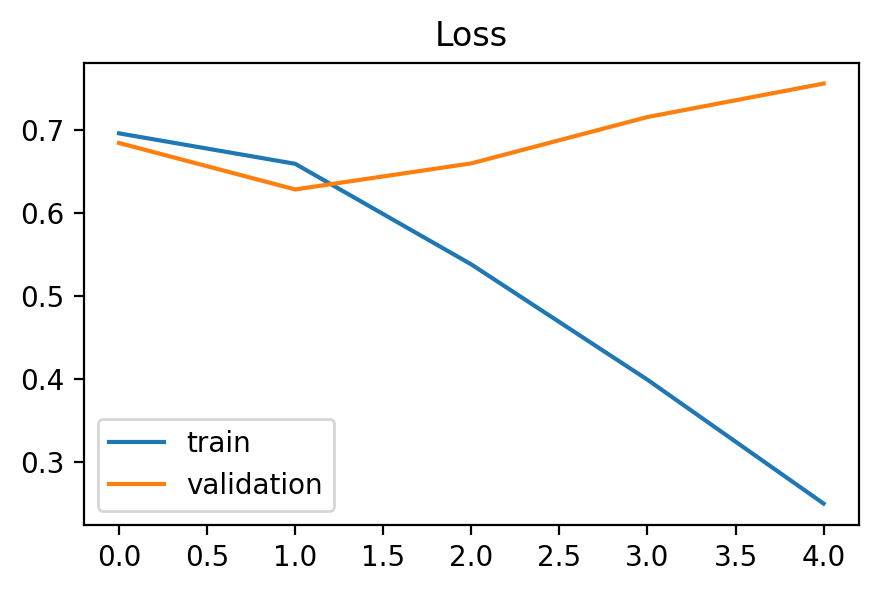

In [20]:
# Train model

siamese_bert_cls.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
                         loss=loss_func,
                         metrics=metric)

history = siamese_bert_cls.fit(x=[X_train_ids_1, X_train_ids_2, X_train_mask_1, X_train_mask_2], y=y_train,
                              validation_split=0.2,
                              batch_size=BATCH_SIZE,
                              epochs=EPOCHS)

plot_history(history)

In [21]:
# Evaluate

loss, accuracy = siamese_bert_cls.evaluate([X_test_ids_1, X_test_ids_2, X_test_mask_1, X_test_mask_2], y=y_test, verbose=0)
print('Test accuracy:', accuracy)

results['siamese_bert_cls'] = {'history': history, 'test_accuracy': accuracy}

Test accuracy: 0.6120689511299133


### 1.2. Siamese-Transformer using last hidden state (dot products)

In [22]:
# Build model

bert = TFAutoModel.from_pretrained(ckpt)
tf.random.set_seed(42)

# Inputs
a = keras.layers.Input(shape=(max_length, ), dtype=tf.int32)
a_mask = keras.layers.Input(shape=(max_length, ), dtype=tf.int32)
b = keras.layers.Input(shape=(max_length, ), dtype=tf.int32)
b_mask = keras.layers.Input(shape=(max_length, ), dtype=tf.int32)

a_dict = {'input_ids': a, 
          'attention_mask': a_mask}
b_dict = {'input_ids': b,
          'attention_mask': b_mask}

# Last hidden state
a_bert = bert(a_dict).last_hidden_state
b_bert = bert(b_dict).last_hidden_state

# Dot products
c = keras.layers.Permute((2, 1))(a_bert)
e = keras.layers.Dot(axes=[1, 2], normalize=True)([c, b_bert])

# Output
x = keras.layers.GlobalMaxPool1D(data_format='channels_last')(e)
output = keras.layers.Dense(1, activation='sigmoid')(x)

siamese_bert_dot = keras.Model(inputs=[a, b, a_mask, b_mask], outputs=output)
siamese_bert_dot.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_6[0][0]',                
 ilBertModel)                   ast_hidden_state=(N               'input_5[0][0]',                
                                one, 100, 768),                   'input_8[0][0]',                
                                 hidden_states=None               'input_7[0][0]']          

Epoch 1/5
47/47 [==============================] - 92s 1s/step - loss: 0.6624 - accuracy: 0.6042 - val_loss: 0.5285 - val_accuracy: 0.7803
Epoch 2/5
47/47 [==============================] - 60s 1s/step - loss: 0.5021 - accuracy: 0.8018 - val_loss: 0.4330 - val_accuracy: 0.8288
Epoch 3/5
47/47 [==============================] - 60s 1s/step - loss: 0.3671 - accuracy: 0.8786 - val_loss: 0.4086 - val_accuracy: 0.8221
Epoch 4/5
47/47 [==============================] - 60s 1s/step - loss: 0.2608 - accuracy: 0.9278 - val_loss: 0.3819 - val_accuracy: 0.8437
Epoch 5/5
47/47 [==============================] - 60s 1s/step - loss: 0.1830 - accuracy: 0.9612 - val_loss: 0.3789 - val_accuracy: 0.8396


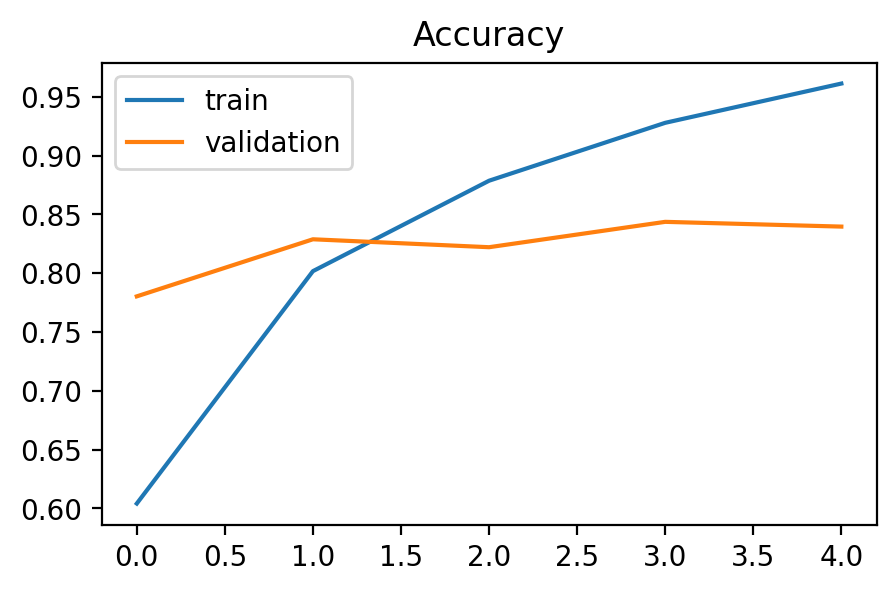

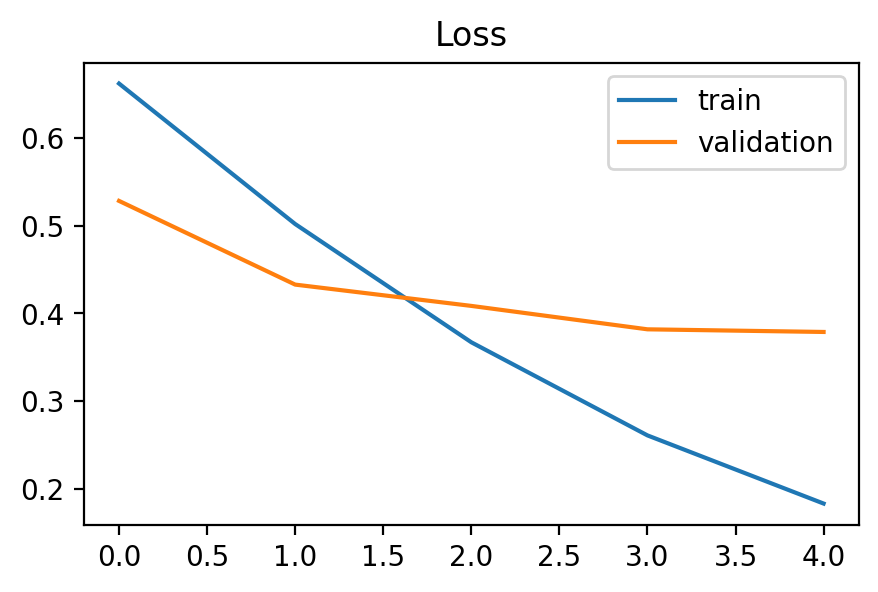

In [23]:
# Train model

siamese_bert_dot.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
                         loss=loss_func, metrics=metric)
                
history = siamese_bert_dot.fit(x=[X_train_ids_1, X_train_ids_2, X_train_mask_1, X_train_mask_2], y=y_train,
                              validation_split=0.2,
                              batch_size=BATCH_SIZE,
                              epochs=EPOCHS)

plot_history(history)

In [24]:
# Evaluate

loss, accuracy = siamese_bert_dot.evaluate([X_test_ids_1, X_test_ids_2, X_test_mask_1, X_test_mask_2], y=y_test, verbose=0)
print('Test accuracy:', accuracy)

results['siamese_bert_dot'] = {'history': history, 'test_accuracy': accuracy}

Test accuracy: 0.8071120977401733


## 2. Siamese-GRU

### Preprocessing

In [25]:
# Split original data to train and test sets (use the same random_state)

train, test = train_test_split(ds, test_size=0.2, random_state=42, shuffle=True)
train.shape

(3708, 3)

### Tokenize

In [26]:
# Combine two feature columns for tokenization
train_text = train[:, :2].reshape(-1)

# Tokenize feature texts
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_text)

vocab_size = len(tokenizer.word_index)

encoded_X_train = tokenizer.texts_to_sequences(train_text)
encoded_X_train_padded = keras.preprocessing.sequence.pad_sequences(encoded_X_train, 
                                                                    maxlen=max_length,
                                                                    padding='post', 
                                                                    truncating='post')

print('Total number of words:', vocab_size)
print('Max sentence length:', max([len(i) for i in encoded_X_train]))

Total number of words: 8181
Max sentence length: 80


In [27]:
# Reshape to the original shape
X_train = encoded_X_train_padded.reshape((-1, 2, max_length))
X_train.shape

(3708, 2, 100)

In [28]:
y_train = train[:, -1].astype(np.int32)

In [29]:
# Repeat the same process for test set

test_text = test[:, :2].reshape(-1)
encoded_X_test = tokenizer.texts_to_sequences(test_text)
encoded_X_test_padded = keras.preprocessing.sequence.pad_sequences(encoded_X_test, 
                                                                    maxlen=max_length,
                                                                    padding='post', 
                                                                    truncating='post')
X_test = encoded_X_test_padded.reshape((-1, 2, max_length))
y_test = test[:, -1].astype(np.int32)

### Preparation step for training

In [30]:
# Set new learning rate since we're training from scratch
LR = 5e-3

### 2.1. Siamese-GRU (absolute difference)

In [31]:
# Build model

embed_size = 64
tf.random.set_seed(42)

# GRU
gru = keras.Sequential([
    keras.layers.Embedding(vocab_size+1, embed_size, mask_zero=True),
    keras.layers.GRU(64, dropout=0.2, recurrent_dropout=0.2),
])

# Inputs
a = keras.layers.Input(shape=(max_length, ), dtype=tf.int32)
b = keras.layers.Input(shape=(max_length, ), dtype=tf.int32)
a_gru = gru(a)
b_gru = gru(b)

# Absolute difference
e = keras.layers.Subtract()([a_gru, b_gru])
e = keras.layers.Lambda(lambda x: abs(x))(e)

# Output
output = keras.layers.Dense(1, activation='sigmoid')(e)
siamese_gru_abs = keras.Model(inputs=[a, b], outputs=output)
siamese_gru_abs.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64)           548608      ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 subtract_1 (Subtract)          (None, 64)           0           ['sequential[0][0]',       

In [32]:
# Train model

siamese_gru_abs.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
                         loss=loss_func,
                         metrics=metric)

history = siamese_gru_abs.fit([X_train[:, 0], X_train[:, 1]], y_train, 
                            batch_size=BATCH_SIZE, 
                            epochs=EPOCHS,
                            validation_split=0.2)

Epoch 1/5
47/47 [==============================] - 43s 785ms/step - loss: 0.6937 - accuracy: 0.5071 - val_loss: 0.6911 - val_accuracy: 0.5270
Epoch 2/5
47/47 [==============================] - 33s 699ms/step - loss: 0.6293 - accuracy: 0.6746 - val_loss: 0.6620 - val_accuracy: 0.6065
Epoch 3/5
47/47 [==============================] - 33s 696ms/step - loss: 0.4148 - accuracy: 0.8149 - val_loss: 0.7427 - val_accuracy: 0.6105
Epoch 4/5
47/47 [==============================] - 31s 656ms/step - loss: 0.2317 - accuracy: 0.9134 - val_loss: 0.8953 - val_accuracy: 0.6186
Epoch 5/5
47/47 [==============================] - 32s 694ms/step - loss: 0.1135 - accuracy: 0.9680 - val_loss: 0.9754 - val_accuracy: 0.6482


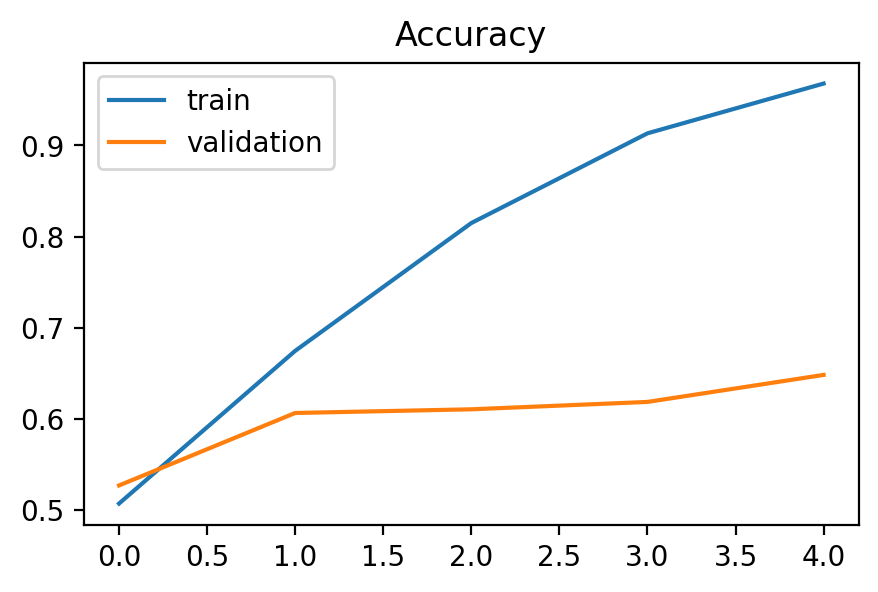

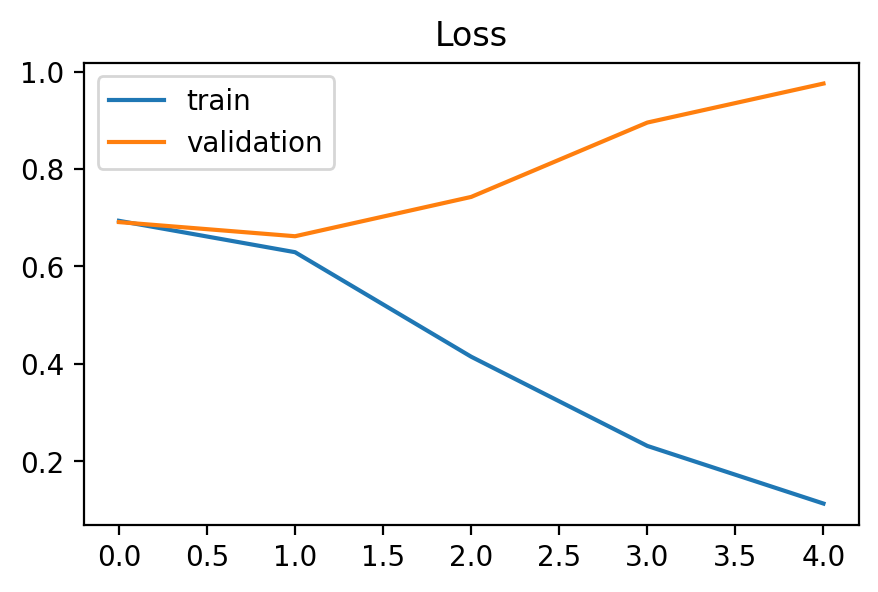

In [33]:
plot_history(history)

In [34]:
# Evaluate

loss, accuracy = siamese_gru_abs.evaluate([X_test[:, 0], X_test[:, 1]], y_test, verbose=0)
print('Test accuracy:', accuracy)

results['siamese_gru_abs'] = {'history': history, 'test_accuracy': accuracy}

Test accuracy: 0.6379310488700867


### 2.2. Siamese-GRU (dot products)

In [35]:
# Build model

embed_size = 64
tf.random.set_seed(42)

# GRU
gru = keras.Sequential([
    keras.layers.Embedding(vocab_size+1, embed_size, mask_zero=True),
    keras.layers.GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)
])

# Input
a = keras.layers.Input(shape=(max_length, ), dtype=tf.int32)
b = keras.layers.Input(shape=(max_length, ), dtype=tf.int32)
a_gru = gru(a)
b_gru = gru(b)

# Dot products
c = keras.layers.Permute((2, 1))(a_gru)
e = keras.layers.Dot(axes=[1, 2], normalize=True)([c, b_gru])

# Output
e = keras.layers.GlobalMaxPool1D(data_format='channels_last')(e)
output = keras.layers.Dense(1, activation='sigmoid')(e)

siamese_gru_dot = keras.Model(inputs=[a, b], outputs=output)
siamese_gru_dot.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, 64)     548608      ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
                                                                                                  
 input_12 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 64, 100)      0           ['sequential_1[0][0]']     

In [36]:
# Train model

siamese_gru_dot.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
                        loss=loss_func, 
                        metrics=metric)

history = siamese_gru_dot.fit([X_train[:, 0], X_train[:, 1]], y_train, 
                              batch_size=BATCH_SIZE, 
                              epochs=EPOCHS,
                              validation_split=0.2)

Epoch 1/5
47/47 [==============================] - 40s 746ms/step - loss: 0.7012 - accuracy: 0.4831 - val_loss: 0.6851 - val_accuracy: 0.5795
Epoch 2/5
47/47 [==============================] - 33s 696ms/step - loss: 0.6564 - accuracy: 0.6824 - val_loss: 0.6593 - val_accuracy: 0.6159
Epoch 3/5
47/47 [==============================] - 32s 674ms/step - loss: 0.5713 - accuracy: 0.7680 - val_loss: 0.6303 - val_accuracy: 0.6375
Epoch 4/5
47/47 [==============================] - 31s 651ms/step - loss: 0.4257 - accuracy: 0.8361 - val_loss: 0.6436 - val_accuracy: 0.6509
Epoch 5/5
47/47 [==============================] - 31s 668ms/step - loss: 0.2905 - accuracy: 0.9076 - val_loss: 0.6677 - val_accuracy: 0.6186


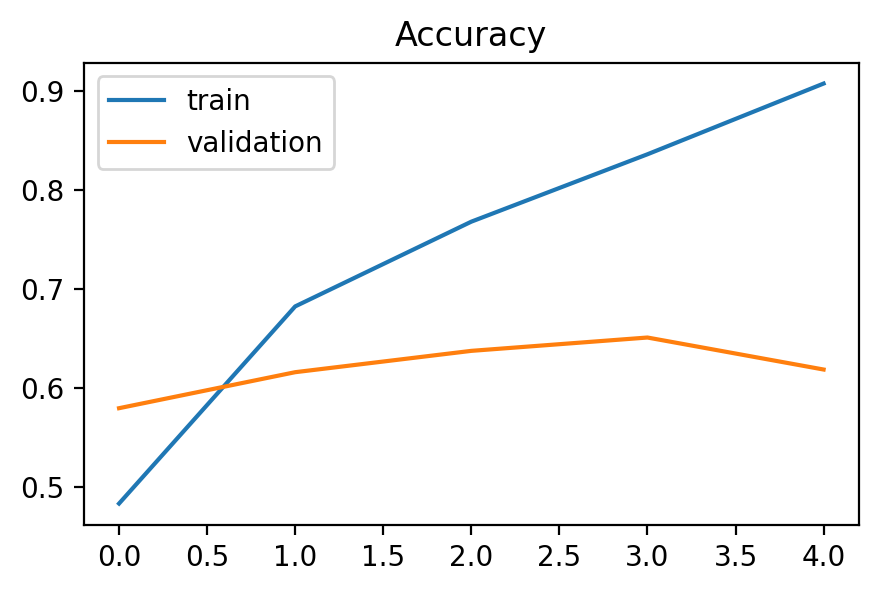

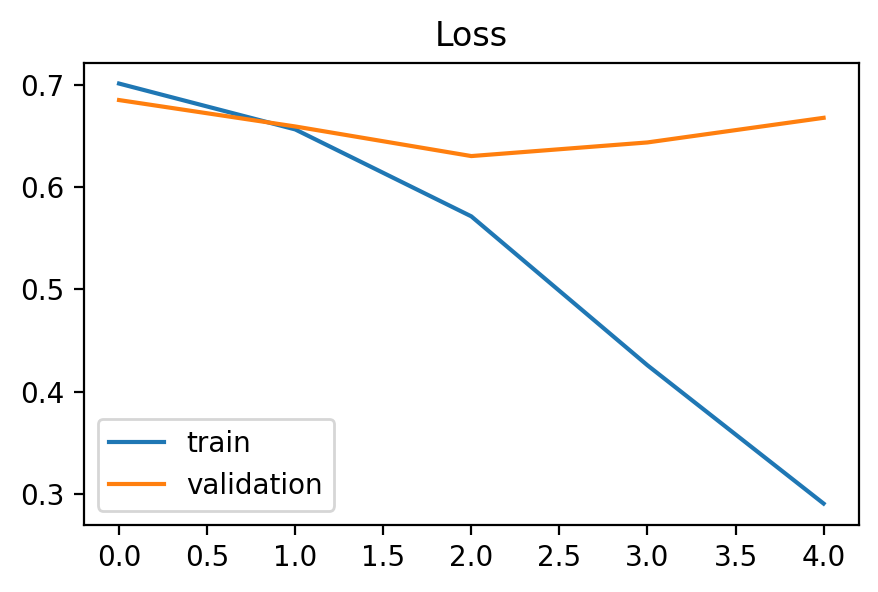

In [37]:
plot_history(history)

In [38]:
# Evaluate

loss, accuracy = siamese_gru_dot.evaluate([X_test[:, 0], X_test[:, 1]], y_test, verbose=0)
print('Test accuracy:', accuracy)

results['siamese_gru_dot'] = {'history': history, 'test_accuracy': accuracy}

Test accuracy: 0.6056034564971924


## Benchmarking

In [39]:
epochs = range(5)
models = []
validation_acc = []
test_acc = []

for model in results:
    models.append(model)
    validation_acc.append(results[model]['history'].history['val_accuracy'])
    test_acc.append(results[model]['test_accuracy'])

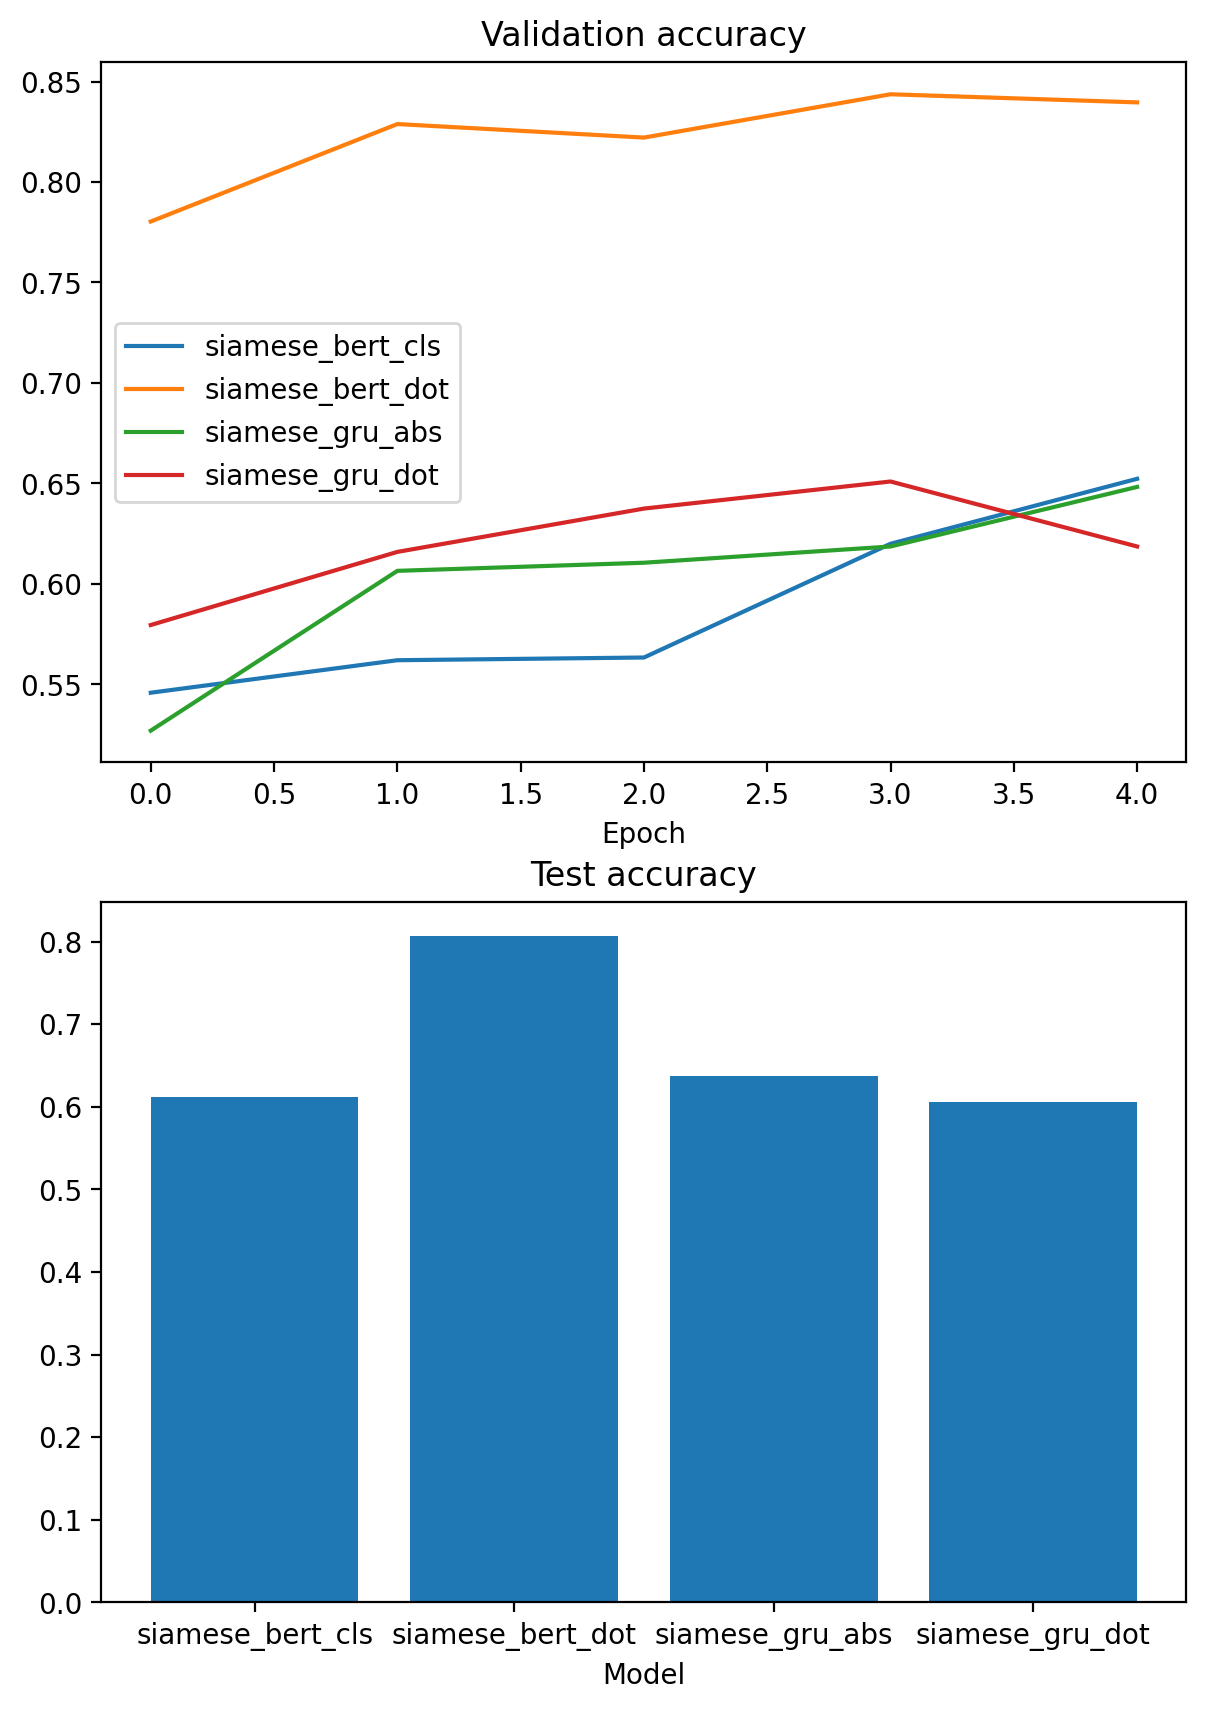

In [40]:
plt.figure(figsize=(7, 10))

# Plot validation accuracy
plt.subplot(211)

for acc in validation_acc:
    plt.plot(epochs, acc)
plt.legend(models)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

# Plot test accuracy
plt.subplot(212)

plt.bar(models, test_acc)
plt.title('Test accuracy')
plt.xlabel('Model')

plt.show()

## Discussion

### Accuracy
* The Siamese network using the dot products of the transfomer last hidden states followed by a global max pooling layer yielded the best scores among the four models.

### Overfitting
* As clearly observed during training, all four models were prone to overfitting after 2 epochs, which could be due to the small training dataset.
* However, the transformer-based models suffered less overfitting than the GRU-based, thanks to the pretrained weights of the transformer having better generalization capability.

### Joining Operations (for tranformer-based models)
* The hidden states dot products operation generated superior results compared to the CLS tokens absolute difference.
* Using CLS tokens means the time dimension was reduced prior to the matching operation, whereas using last hidden states dot products followed by global max pooling reversed the order.
* In this work, the latter mechanism seems better in preserving generalization capability.
* This finding is consistent with the proposal in the referenced Siamese model paper, which stated that allowing *interaction* to come before *representation* was the better approach.

## Reference

https://iopscience.iop.org/article/10.1088/1742-6596/1684/1/012074